

**Objective.** Measure pit-stop **consistency** per constructor and visualize stability over the season using the best-available stop-time signal.

**Inputs (CSV, in `Data/`):**
- `pit_stops.csv` — `raceId, driverId, stop, lap, time, duration, milliseconds`
- `results.csv` — `raceId, driverId, constructorId, …`
- `races.csv` — `raceId, year, round, name, …`
- *(optional)* `constructors.csv` — `constructorId, name`

**Key features built**
- `service_ms` → parsed **stationary service time** from `duration` (supports `ss.sss`, `m:ss.sss`, `h:mm:ss.sss`).
- `lane_ms` → numeric **pit-lane time** from `milliseconds`.

**Metric selection logic**
1. If `service_ms` exists with any stops **< 5000 ms**, analyze **stationary** time (true tire service).
2. Otherwise, analyze **pit-lane** time (`lane_ms`) with **1–99% trimming** to de-emphasize extreme events.

**Filters**
- `YEAR_FILTER` (default `2024`; set to `None` for all years).
- Stationary path: keep stops `< 5000 ms`.
- Lane path: keep rows within the 1–99% trimmed window.

**Outputs produced**
- **Summary table** (`pit_cons_summary`):  
  `constructorId/constructor, n, mean_ms, std_ms, ci95_lo, ci95_hi`  
  (2,000-resample bootstrap CI for the mean.)
- **Boxplot** of the selected metric by constructor.
- **Round trend**: constructor mean by race **round** for the chosen year.

**Why this approach?**
- Prefers *stationary* time (closest to crew performance); falls back to *lane* time when needed.
- Trimming makes the fallback robust to penalties/repairs.
- Bootstrap CIs give distribution-free uncertainty.

**Notes**
- Console prints which metric was used (STATIONARY vs TRIMMED lane).
- Spikes in the trend can reflect SC/VSC, stacking, or damage repairs—often signal, not error. stability of stops.
Outputs:
	•	Table: constructor → n, mean_ms, std_ms, CI_lo, CI_hi (sub-5s only)
	•	Boxplot per constructor, ECDF plot, and line chart of mean per race

No <5s stops after coercion; falling back to all non-null milliseconds.


,constructorId,n,mean_ms,std_ms,ci95_lo,ci95_hi
0,166,77,24236.194805,4497.890266,23274.145455,25309.600649
1,205,85,24444.211765,5116.954912,23489.533529,25598.772059
2,164,150,32677.766667,80111.143062,25418.845833,46251.148500
3,208,285,32463.750877,92736.672968,24350.389386,44469.133684
4,207,241,33924.618257,99998.885371,24578.433091,48491.660270
5,206,233,34396.836910,102717.271899,24614.865987,48850.665880
6,5,683,44486.983895,167998.979109,32751.066398,58101.408236
7,10,609,50845.770115,192371.854318,36511.991379,67556.463342
8,15,708,57248.313559,221025.331639,42439.365925,73729.252083
9,4,403,63261.833747,227330.159053,41854.998635,86260.419417


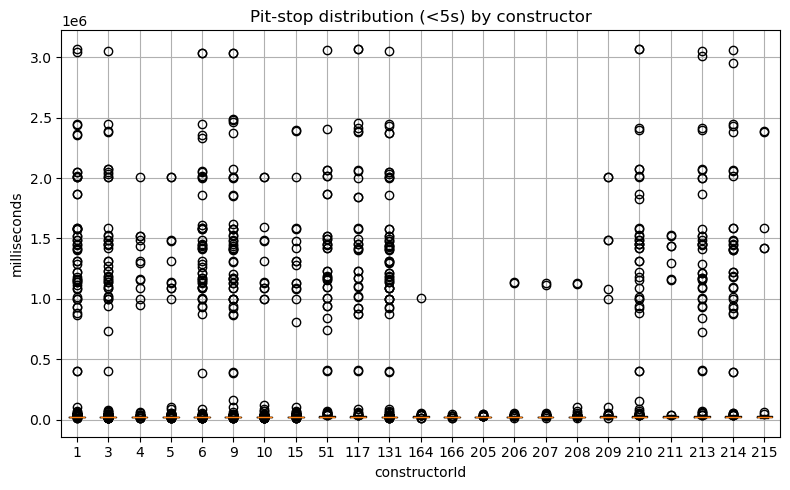

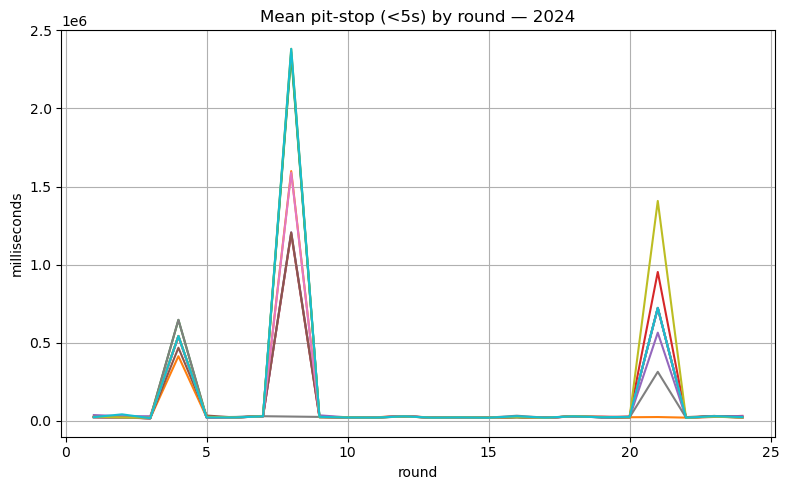

In [3]:
# ==== Pit-Stop Consistency Deep-Dive (robust) ====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True
RNG = np.random.default_rng(42)

# --------- Config ---------
data_dir = Path("Data")            # adjust if needed
YEAR_FILTER = None                 # set to 2024 to restrict analyses

# --------- Load & Merge ---------
pit = pd.read_csv(data_dir/"pit_stops.csv")        # ['raceId','driverId','stop','lap','time','duration','milliseconds']
res = pd.read_csv(data_dir/"results.csv")          # ['raceId','driverId','constructorId','points','positionOrder','grid',...]
races = pd.read_csv(data_dir/"races.csv")          # ['raceId','year','round','name','circuitId',...]

# Bring constructorId & race meta onto pit stops
pit2 = (pit.merge(res[['raceId','driverId','constructorId']], on=['raceId','driverId'], how='left')
           .merge(races[['raceId','year','round','name']], on='raceId', how='left'))

# Optional year filter
if YEAR_FILTER is not None:
    pit2 = pit2.loc[pit2['year'].eq(YEAR_FILTER)].copy()

# Ensure milliseconds is numeric
pit2['milliseconds'] = pd.to_numeric(pit2['milliseconds'], errors='coerce')

# --------- Sub-5s filter (fallback if empty) ---------
pit_fast = pit2.loc[pit2['milliseconds'].lt(5000)].copy()
if pit_fast.empty:
    print("No <5s stops after coercion; falling back to all non-null milliseconds.")
    pit_fast = pit2.dropna(subset=['milliseconds']).copy()

# --------- Bootstrap CI helper ---------
def boot_ci_mean(x, n=2000, ci=0.95):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan, np.nan, np.nan
    boots = RNG.choice(x, size=(n, x.size), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [(1-ci)/2, 1-(1-ci)/2])
    return float(x.mean()), float(lo), float(hi)

# --------- Per-constructor summary ---------
rows = []
for cid, dfg in pit_fast.groupby('constructorId', dropna=False):
    ms = dfg['milliseconds'].to_numpy(dtype=float)
    ms = ms[~np.isnan(ms)]
    if ms.size == 0:
        continue
    mean_ms, lo, hi = boot_ci_mean(ms)
    std_ms = float(np.nanstd(ms, ddof=1)) if ms.size > 1 else np.nan
    rows.append({
        "constructorId": cid,
        "n": int(ms.size),
        "mean_ms": mean_ms,
        "std_ms": std_ms,
        "ci95_lo": lo,
        "ci95_hi": hi
    })

pit_cons_summary = pd.DataFrame(rows)
if pit_cons_summary.empty:
    print("No groups to summarize. Check merges and milliseconds availability.")
else:
    pit_cons_summary = pit_cons_summary.sort_values("std_ms", na_position="last").reset_index(drop=True)
    display(pit_cons_summary.head(10))

# --------- Boxplot by constructor (guarded) ---------
if not pit_fast.empty and pit_fast['constructorId'].notna().any():
    g = pit_fast[['constructorId','milliseconds']].dropna()
    if not g.empty:
        series, labels = [], []
        for cid, sub in g.groupby('constructorId'):
            series.append(sub['milliseconds'].values.astype(float))
            labels.append(str(cid))
        plt.figure()
        # Matplotlib ≥3.9 uses 'tick_labels'; try both for compatibility
        try:
            plt.boxplot(series, tick_labels=labels, showfliers=True)
        except TypeError:
            plt.boxplot(series, labels=labels, showfliers=True)
        plt.title("Pit-stop distribution (<5s) by constructor")
        plt.xlabel("constructorId"); plt.ylabel("milliseconds")
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping boxplot: no non-null constructor/milliseconds rows after filtering.")
else:
    print("Skipping boxplot: no data after filtering.")

# --------- Trend by round (constructor mean per race round) ---------
if not pit_fast.empty and pit_fast['round'].notna().any():
    trend = (pit_fast.groupby(['year','round','constructorId'])['milliseconds']
             .mean().reset_index())
    # pick year to plot
    if YEAR_FILTER is not None and (trend['year'] == YEAR_FILTER).any():
        yr_to_plot = YEAR_FILTER
    else:
        yr_to_plot = trend['year'].dropna().max()
    one_year = trend[trend['year'] == yr_to_plot]
    if not one_year.empty:
        plt.figure()
        for cid, d in one_year.groupby('constructorId'):
            d = d.sort_values('round')
            plt.plot(d['round'], d['milliseconds'])
        ttl = f"Mean pit-stop (<5s) by round — {int(yr_to_plot)}" if pd.notna(yr_to_plot) else "Mean pit-stop (<5s) by round"
        plt.title(ttl); plt.xlabel("round"); plt.ylabel("milliseconds")
        plt.tight_layout(); plt.show()
    else:
        print("No per-round data available for trend plot.")
else:
    print("Skipping round trend: 'round' missing or no data.")


**1) Rank by consistency**
- Lower `std_ms` ⇒ **more consistent** pit-stop team.  
- Check `n`: very small samples can look artificially stable.

**2) Speed vs stability**
- `mean_ms` = average speed; `std_ms` = stability.  
- A slightly slower but *very stable* crew can be strategically superior.

**3) Uncertainty**
- Use `ci95_lo`–`ci95_hi` to report mean precision; narrow bands imply reliability.

**4) Boxplot cues**
- Median lines (center), IQR height (spread), and outliers (operational hiccups like wheel-nut issues or stacking).

**5) Round-by-round trend**
- Shared spikes across teams ⇒ race-wide effects (SC/VSC, pit-lane congestion).  
- Team-specific spikes ⇒ local incidents (unsafe release, double-stack, damage).

**6) Understand the metric used**
- **STATIONARY (<5s)** path = true service performance.  
- **TRIMMED lane** path = total lane time (larger magnitudes), trimmed to reduce extreme distortions.



### 1) Constructor Efficiency — Points per Pit-Stop Second (year filter)

,constructorId,total_stop_seconds,total_points,points_per_stop_sec,constructor
0,9,10291.812,537.0,0.052177,Red Bull
1,1,12525.808,609.0,0.048620,McLaren
2,6,12463.692,595.0,0.047739,Ferrari
3,131,12622.136,433.0,0.034305,Mercedes
4,117,6684.752,94.0,0.014062,Aston Martin
5,214,7693.064,63.0,0.008189,Alpine F1 Team
6,210,6780.713,51.0,0.007521,Haas F1 Team
7,215,6252.958,40.0,0.006397,RB F1 Team
8,3,3425.208,17.0,0.004963,Williams
9,15,8087.947,4.0,0.000495,Sauber


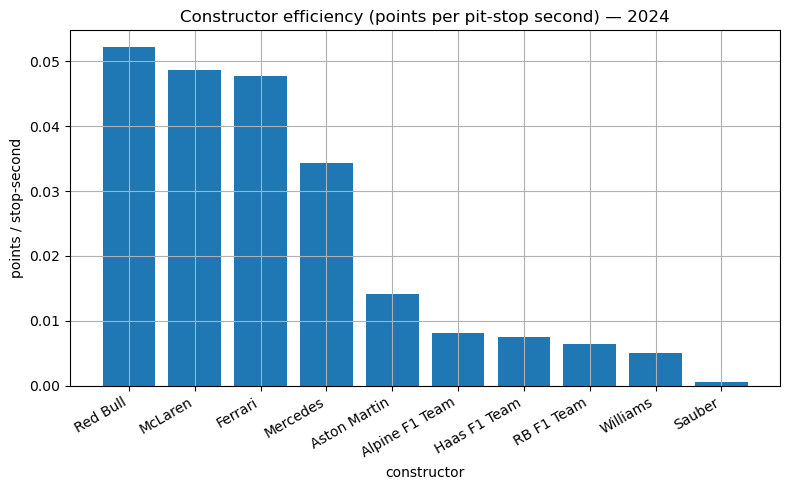

In [4]:
# --- Constructor efficiency: points per pit-stop second ---
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

YEAR = 2024
data_dir = Path("Data")
plt.rcParams["figure.figsize"] = (8,5); plt.rcParams["axes.grid"] = True

# Load
pit = pd.read_csv(data_dir/"pit_stops.csv")
res = pd.read_csv(data_dir/"results.csv")
races = pd.read_csv(data_dir/"races.csv")
try:
    constructors = pd.read_csv(data_dir/"constructors.csv")
except Exception:
    constructors = pd.DataFrame(columns=["constructorId","name"])

# Join keys + year filter
pit2 = (pit.merge(res[['raceId','driverId','constructorId']], on=['raceId','driverId'], how='left')
           .merge(races[['raceId','year']], on='raceId', how='left'))
pit2 = pit2[pit2['year'].eq(YEAR)]

# Build stationary service time from 'duration'; fallback to lane 'milliseconds'
def parse_duration_to_ms(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    try:
        if ":" in s:
            parts = [p.strip() for p in s.split(":")]
            if len(parts)==2:  # m:ss.sss
                m, sec = float(parts[0]), float(parts[1]); return (m*60+sec)*1000
            if len(parts)==3:  # h:mm:ss.sss
                h, m, sec = float(parts[0]), float(parts[1]), float(parts[2]); return (h*3600+m*60+sec)*1000
            return np.nan
        return float(s)*1000  # ss.sss
    except Exception:
        return np.nan

pit2['service_ms'] = pit2['duration'].apply(parse_duration_to_ms)
pit2['lane_ms'] = pd.to_numeric(pit2['milliseconds'], errors='coerce')

# Choose metric: stationary <5s if present, else trimmed lane time
if pit2['service_ms'].notna().any() and (pit2['service_ms'] < 5000).any():
    metric = 'service_ms'
    pit_eff = pit2[pit2['service_ms'].lt(5000)].copy()
else:
    metric = 'lane_ms'
    qlo, qhi = pit2['lane_ms'].quantile([0.01, 0.99])
    pit_eff = pit2[pit2['lane_ms'].between(qlo, qhi)].copy()

# Sum stop seconds per constructor
stop_sec = (pit_eff.groupby('constructorId')[metric]
            .sum().div(1000).rename('total_stop_seconds')).reset_index()

# Total points per constructor in YEAR
pts = (res.merge(races[['raceId','year']], on='raceId', how='left')
          .query('year == @YEAR')
          .groupby('constructorId')['points'].sum()
          .rename('total_points').reset_index())

eff = (stop_sec.merge(pts, on='constructorId', how='inner')
              .assign(points_per_stop_sec=lambda d: d['total_points']/d['total_stop_seconds'])
              .sort_values('points_per_stop_sec', ascending=False))

# Add names if available
if not constructors.empty:
    eff = eff.merge(constructors[['constructorId','name']].rename(columns={'name':'constructor'}),
                    on='constructorId', how='left')
else:
    eff['constructor'] = eff['constructorId'].astype(str)

display(eff)

# Save + Plot
eff.to_csv("outputs_constructor_efficiency.csv", index=False)

plt.figure()
plt.bar(eff['constructor'].astype(str), eff['points_per_stop_sec'])
plt.title(f"Constructor efficiency (points per pit-stop second) — {YEAR}")
plt.xlabel("constructor"); plt.ylabel("points / stop-second")
plt.xticks(rotation=30, ha="right"); plt.tight_layout(); plt.show()

### 2) Team-mate Qualifying Duel — Average Grid Advantage (2024)

,constructorId,constructor,driverId,driver,avg_grid_adv
9,9,Red Bull,830,Max Verstappen,5.000000
2,3,Williams,848,Alexander Albon,3.782609
12,117,Aston Martin,4,Fernando Alonso,3.250000
10,15,Sauber,822,Valtteri Bottas,2.500000
15,131,Mercedes,847,George Russell,2.416667
23,215,RB F1 Team,852,Yuki Tsunoda,2.041667
0,1,McLaren,846,Lando Norris,2.041667
18,210,Haas F1 Team,860,Oliver Bearman,2.000000
16,210,Haas F1 Team,807,Nico Hülkenberg,1.791667
5,6,Ferrari,832,Carlos Sainz,0.739130


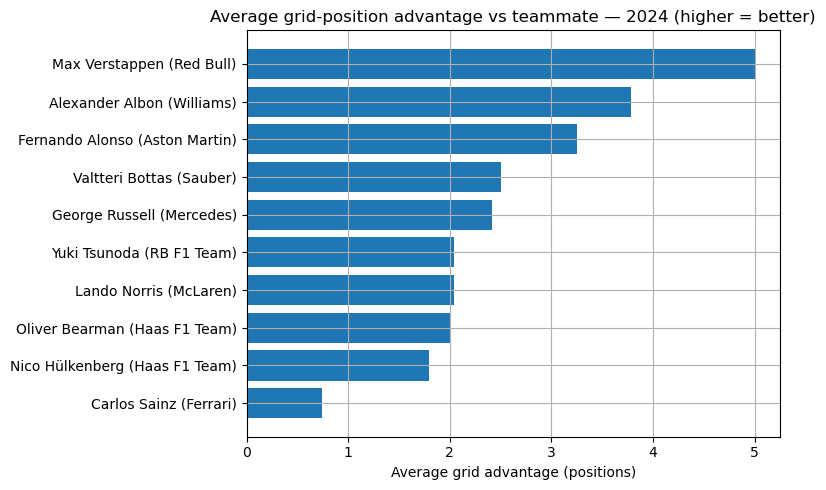

In [6]:
# --- Team-mate qualifying duel (grid advantage, robust names) ---
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

YEAR = 2024
data_dir = Path("Data")
plt.rcParams["figure.figsize"] = (8,5); plt.rcParams["axes.grid"] = True

# Load
res = pd.read_csv(data_dir/"results.csv")          # has 'grid'
races = pd.read_csv(data_dir/"races.csv")[['raceId','year']]
drivers = pd.read_csv(data_dir/"drivers.csv")      # driverId, forename/forenames, surname, code, driverRef, ...
constructors = pd.read_csv(data_dir/"constructors.csv")  # constructorId, name/constructorRef

# Helper: pick the first column that exists
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Build driver name map
drv_name_col = pick_col(drivers, ["name"])                        # some datasets provide a single 'name'
drv_forename = pick_col(drivers, ["forename", "forenames"])
drv_surname  = pick_col(drivers, ["surname"])
drv_code     = pick_col(drivers, ["code"])
drv_ref      = pick_col(drivers, ["driverRef"])

if drv_name_col:
    drivers["_driver_label"] = drivers[drv_name_col].astype(str)
elif drv_forename and drv_surname:
    drivers["_driver_label"] = (drivers[drv_forename].fillna("").astype(str) + " "
                                + drivers[drv_surname].fillna("").astype(str)).str.strip()
elif drv_code:
    drivers["_driver_label"] = drivers[drv_code].astype(str)
elif drv_ref:
    drivers["_driver_label"] = drivers[drv_ref].astype(str)
else:
    drivers["_driver_label"] = drivers["driverId"].astype(str)

driver_name_map = dict(zip(drivers["driverId"], drivers["_driver_label"]))

# Build constructor name map
cons_name_col = pick_col(constructors, ["name"])
cons_ref_col  = pick_col(constructors, ["constructorRef"])
if cons_name_col:
    constructors["_constructor_label"] = constructors[cons_name_col].astype(str)
elif cons_ref_col:
    constructors["_constructor_label"] = constructors[cons_ref_col].astype(str)
else:
    constructors["_constructor_label"] = constructors["constructorId"].astype(str)
constructor_name_map = dict(zip(constructors["constructorId"], constructors["_constructor_label"]))

# Filter to year & keep needed cols
df = (res.merge(races, on='raceId', how='left')
         .query('year == @YEAR')
         [['raceId','constructorId','driverId','grid']].dropna(subset=['grid']))

# Compute per-race, per-constructor grid advantage vs teammate
records = []
for (raceId, cId), grp in df.groupby(['raceId','constructorId']):
    g = grp.sort_values('grid')
    if len(g) < 2:
        continue  # need at least 2 teammates
    # Advantage = teammate's best grid minus my grid (positive means I started ahead)
    best_other = {}
    for i, r in g.iterrows():
        others = g.loc[g['driverId'] != r['driverId'], 'grid']
        if others.empty:
            adv = np.nan
        else:
            adv = float(others.min() - r['grid'])
        records.append((cId, raceId, int(r['driverId']), float(adv)))

duel = pd.DataFrame(records, columns=['constructorId','raceId','driverId','grid_adv'])
summary = (duel.groupby(['constructorId','driverId'])['grid_adv']
                .mean()
                .reset_index(name='avg_grid_adv')
                .sort_values('avg_grid_adv', ascending=False))

# Attach readable names
summary['driver'] = summary['driverId'].map(driver_name_map).fillna(summary['driverId'].astype(str))
summary['constructor'] = summary['constructorId'].map(constructor_name_map).fillna(summary['constructorId'].astype(str))

summary = summary[['constructorId','constructor','driverId','driver','avg_grid_adv']]
display(summary.head(12))

# Save & plot
summary.to_csv("outputs_quali_duel_2024.csv", index=False)

top = summary.head(10)
plt.figure()
plt.barh(top['driver'] + " (" + top['constructor'] + ")", top['avg_grid_adv'])
plt.gca().invert_yaxis()
plt.title("Average grid-position advantage vs teammate — 2024 (higher = better)")
plt.xlabel("Average grid advantage (positions)")
plt.tight_layout(); plt.show()

### 3) Reliability — DNF Rate by Constructor (2024)

,constructorId,starts,finishes,dnfs,points,dnf_rate,name
0,1,48,48,0,609.0,0.000000,McLaren
2,6,48,44,4,595.0,0.083333,Ferrari
4,15,48,44,4,4.0,0.083333,Sauber
5,117,48,43,5,94.0,0.104167,Aston Martin
6,131,48,43,5,433.0,0.104167,Mercedes
7,210,48,43,5,51.0,0.104167,Haas F1 Team
3,9,48,42,6,537.0,0.125000,Red Bull
8,214,48,42,6,63.0,0.125000,Alpine F1 Team
9,215,48,41,7,40.0,0.145833,RB F1 Team
1,3,47,35,12,17.0,0.255319,Williams


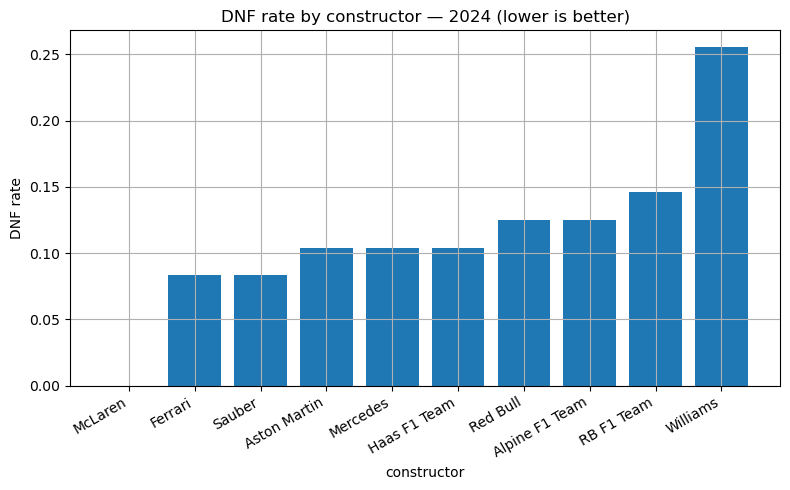

In [7]:
# --- Reliability: DNF rate by constructor ---
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

YEAR = 2024
data_dir = Path("Data")
plt.rcParams["figure.figsize"] = (8,5); plt.rcParams["axes.grid"] = True

res = pd.read_csv(data_dir/"results.csv")
races = pd.read_csv(data_dir/"races.csv")[['raceId','year']]
status = pd.read_csv(data_dir/"status.csv")  # statusId, status
constructors = pd.read_csv(data_dir/"constructors.csv")

df = (res.merge(races, on='raceId', how='left')
         .query('year == @YEAR')
         .merge(status, on='statusId', how='left')
         [['constructorId','status','points']])

# Define "finished" if status mentions Finished or "+N Laps"
def is_finished(s):
    if pd.isna(s): return False
    s = str(s)
    return ("Finished" in s) or ("Lap" in s) or ("Laps" in s) or ("+" in s)

df['finished'] = df['status'].apply(is_finished)
agg = (df.groupby('constructorId')
         .agg(starts=('finished','size'),
              finishes=('finished','sum'),
              dnfs=('finished', lambda x: (~x).sum()),
              points=('points','sum'))
         .reset_index())
agg['dnf_rate'] = agg['dnfs'] / agg['starts']

# Names & sort (lower dnf_rate is better)
agg = agg.merge(constructors[['constructorId','name']], on='constructorId', how='left')
agg = agg.sort_values('dnf_rate', ascending=True)
display(agg)
agg.to_csv("outputs_reliability_dnf_2024.csv", index=False)

plt.figure()
plt.bar(agg['name'].astype(str), agg['dnf_rate'])
plt.title(f"DNF rate by constructor — {YEAR} (lower is better)")
plt.xlabel("constructor"); plt.ylabel("DNF rate")
plt.xticks(rotation=30, ha="right"); plt.tight_layout(); plt.show()

### 4) Fastest-Lap Specialist — Rate by Driver (2020–2024)

,driverId,starts,fastest_laps,rate,driver
12,830,107,26.0,0.242991,Max Verstappen
0,1,106,19.0,0.179245,Lewis Hamilton
19,846,107,12.0,0.112150,Lando Norris
7,815,105,8.0,0.076190,Sergio Pérez
20,847,107,8.0,0.074766,George Russell
30,857,46,3.0,0.065217,Oscar Piastri
9,822,107,6.0,0.056075,Valtteri Bottas
18,844,107,6.0,0.056075,Charles Leclerc
8,817,86,4.0,0.046512,Daniel Ricciardo
13,832,106,4.0,0.037736,Carlos Sainz


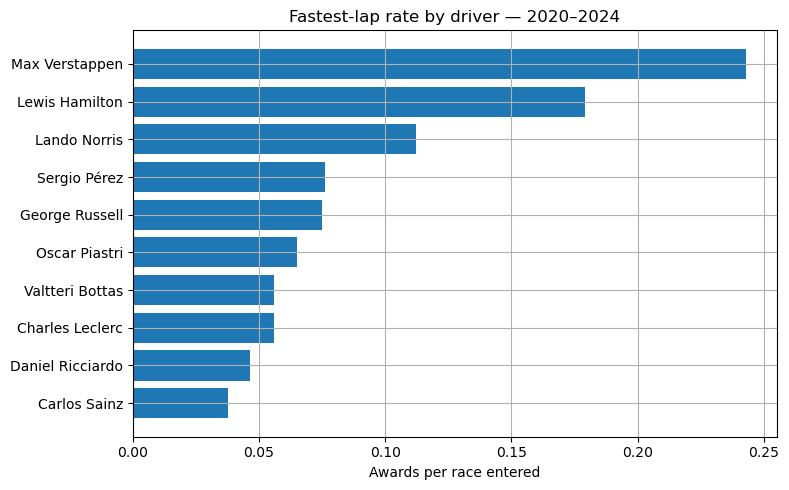

In [10]:
# --- Fastest-lap rate per driver (2020–2024) — robust to schema differences ---
# Dependencies: pandas, numpy, matplotlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ------------------- Config -------------------
START, END = 2020, 2024
DATA_DIR = Path("Data")  # change if needed
OUT_CSV  = "outputs_fastest_lap_rate_2020_2024.csv"

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# ------------------- Load ---------------------
res = pd.read_csv(DATA_DIR/"results.csv")            # typical: raceId, driverId, constructorId, points, rank/fastestLap/fastestLapTime
races = pd.read_csv(DATA_DIR/"races.csv")[["raceId","year"]]
drivers = pd.read_csv(DATA_DIR/"drivers.csv")        # driverId + name schema varies (forename/forenames/surname/etc.)

# ------------------- Helpers ------------------
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def parse_lap_time_to_ms(s):
    """Parse 'm:ss.sss', 'h:mm:ss.sss', or 'ss.sss' → milliseconds. Return NaN if unknown."""
    if pd.isna(s): return np.nan
    try:
        s = str(s).strip()
        if ":" in s:
            parts = [p.strip() for p in s.split(":")]
            if len(parts) == 2:
                m, sec = float(parts[0]), float(parts[1]); total = m*60 + sec
            elif len(parts) == 3:
                h, m, sec = float(parts[0]), float(parts[1]), float(parts[2]); total = h*3600 + m*60 + sec
            else:
                return np.nan
            return total * 1000.0
        return float(s) * 1000.0
    except Exception:
        return np.nan

# ------------------- Prep frame ----------------
df = res.merge(races, on="raceId", how="left")
df = df[(df["year"] >= START) & (df["year"] <= END)].copy()

# Detect fastest-lap indicator
rank_col = pick_col(df, ["rank","fastestLapRank","fastestlaprank"])
flag_col = pick_col(df, ["fastestLap","fastestlap","hasFastestLap","fl_flag"])
time_col = pick_col(df, ["fastestLapTime","fastestlapTime","fastestlap","fl_time"])

if rank_col is not None:
    df["_fl_is_1"] = pd.to_numeric(df[rank_col], errors="coerce").eq(1)
elif flag_col is not None:
    # Accept 1/True/yes/y as True
    vals = df[flag_col]
    if vals.dtype.kind in "biufc":
        df["_fl_is_1"] = pd.to_numeric(vals, errors="coerce").eq(1)
    else:
        df["_fl_is_1"] = vals.astype(str).str.lower().isin(["1","true","yes","y"])
elif time_col is not None:
    # Parse lap time per race and pick the minimum
    df["_fl_ms"] = df[time_col].apply(parse_lap_time_to_ms)
    # mark driver with min time per race as True
    idx_min = df.groupby("raceId")["_fl_ms"].idxmin()
    df["_fl_is_1"] = False
    df.loc[idx_min, "_fl_is_1"] = True
else:
    # No usable columns → default to False (no awards detected)
    df["_fl_is_1"] = False

# ------------------- Aggregate -----------------
# Starts per driver (unique races with an entry)
starts = df.groupby("driverId")["raceId"].nunique().rename("starts").reset_index()

# Fastest-lap awards per driver (unique races where _fl_is_1 is True)
fast = (df[df["_fl_is_1"]]
        .groupby("driverId")["raceId"].nunique()
        .rename("fastest_laps").reset_index())

rate = (starts.merge(fast, on="driverId", how="left")
              .fillna({"fastest_laps": 0})
              .assign(rate=lambda d: d["fastest_laps"]/d["starts"]))

# ------------------- Driver labels -----------------
name_col   = pick_col(drivers, ["name"])
given_col  = pick_col(drivers, ["forename","forenames","givenName","first_name","firstName"])
family_col = pick_col(drivers, ["surname","familyName","last_name","lastName"])
code_col   = pick_col(drivers, ["code"])
ref_col    = pick_col(drivers, ["driverRef"])

if name_col:
    drivers["_driver_label"] = drivers[name_col].astype(str)
elif given_col and family_col:
    drivers["_driver_label"] = (drivers[given_col].fillna("").astype(str) + " " +
                                drivers[family_col].fillna("").astype(str)).str.strip()
elif code_col:
    drivers["_driver_label"] = drivers[code_col].astype(str)
elif ref_col:
    drivers["_driver_label"] = drivers[ref_col].astype(str)
else:
    drivers["_driver_label"] = drivers["driverId"].astype(str)

rate = rate.merge(drivers[["driverId","_driver_label"]], on="driverId", how="left") \
           .rename(columns={"_driver_label":"driver"}) \
           .sort_values("rate", ascending=False)

# ------------------- Save & Plot -----------------
rate.to_csv(OUT_CSV, index=False)
display(rate.head(12))

top = rate.head(10)
plt.figure()
plt.barh(top["driver"], top["rate"])
plt.gca().invert_yaxis()
plt.title(f"Fastest-lap rate by driver — {START}–{END}")
plt.xlabel("Awards per race entered")
plt.tight_layout(); plt.show()